In [1]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from VisionUtils import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, SelectFpr, mutual_info_classif
import numpy as np
import tensorflow as tf

In [2]:
tf.enable_eager_execution()

In [3]:
feat1 = np.load("features/feat1.npy")
feat2 = np.load("features/feat2.npy")
labels = np.load("features/labels.npy")
feat3 = np.load("features/feat3.npy")
feat4 = np.load("features/feat4.npy")
labels34 = np.load("features/labels34.npy")

In [4]:
len(feat1.T)

128

In [5]:
f1 = [feat1[i1].reshape(-1,1) for i1 in range(len(feat1))]
f2 = [feat2[i2].reshape(-1,1) for i2 in range(len(feat2))]
cos_d = np.array(
    [ feat_distance_cosine_scalar(f1[i].T, f2[i]) for i in range(len(feat1))]).reshape(-1,1)
eucl_d = np.array([ np.linalg.norm(f1[i]- f2[i]) for i in range(len(feat1))]).reshape(-1,1)
sqr_diff = np.power(np.abs(feat1-feat2), 2)

data_dict = { "labels": labels,
             "cosine_distance": cos_d, 
             "Eucledian_distance": eucl_d,
             "sqaured_difference":sqr_diff}

data = np.hstack([cos_d,eucl_d, sqr_diff])

In [6]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
selecter = SelectKBest(chi2, k = int(0.8*(len(data.T))))
feats = selecter.fit_transform(scaled_data, labels)

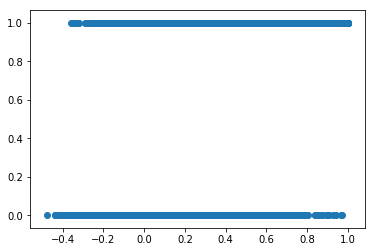

In [7]:
plt.scatter(cos_d, labels)

In [8]:

xtrain, xtest, ytrain, ytest = train_test_split(feats, labels, shuffle = True, random_state = 42)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.regularizers import l1, l2
he_init = tf.keras.initializers.VarianceScaling()

model = Sequential()
model.add(Dense(20, activation = 'elu', kernel_initializer = he_init, 
                kernel_regularizer = l1(0.001), 
                #input_shape = (1,128)
               ))
model.add(Dense(5, activation = 'elu',kernel_initializer = he_init))
model.add(Dense(1, activation = "sigmoid", kernel_initializer = he_init))

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
mcp = ModelCheckpoint("models_chpt/best_modelD.hdf5",verbose = 1, 
                      monitor = "val_loss", save_best_only = True, save_weights_only = True)
red_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor =0.5)
opt = tf.keras.optimizers.Adam(0.001)
model.compile(optimizer = opt, loss = "binary_crossentropy", 
              metrics = ["accuracy"] )

In [ ]:
bz = 1000
epochs = 400
history = model.fit(
    xtrain,
    ytrain,
    epochs = epochs,
    batch_size = bz,
    validation_data =(xtest, ytest),
    callbacks = [mcp, red_lr]
)


In [59]:
model.evaluate(xtest, ytest)

12500/12500 [==============================] - 0s 15us/sample - loss: 0.3888 - acc: 0.8325


[0.3888160006809235, 0.83248]

Text(0.5, 1.0, 'Loss Vs # of epochs')

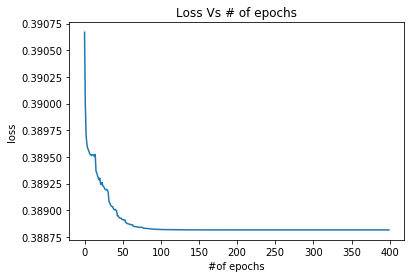

In [60]:
%matplotlib inline 
plt.plot( [i for i in range(epochs)], history.history['val_loss'], label = "validation loss")
plt.xlabel("#of epochs")
plt.ylabel("loss")
plt.title("Loss Vs # of epochs")

Text(0.5, 1.0, 'Loss Vs # of epochs')

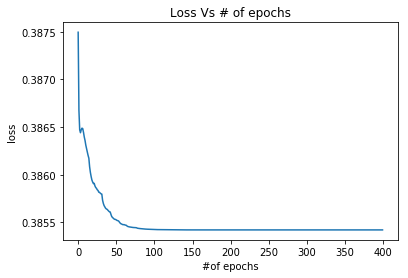

In [58]:
plt.plot([i for i in range(epochs)], history.history['loss'], label = "Train loss")
plt.xlabel("#of epochs")
plt.ylabel("loss")
plt.title("Loss Vs # of epochs")

Text(0.5, 1.0, 'Learning rate Vs # of epochs')

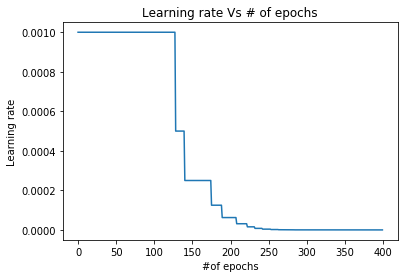

In [49]:
plt.plot([i for i in range(epochs)], history.history['lr'], label = "Train loss")
plt.xlabel("#of epochs")
plt.ylabel("Learning rate")
plt.title("Learning rate Vs # of epochs")

In [190]:
model.evaluate(xtest, ytest)

12500/12500 [==============================] - 0s 15us/sample - loss: 0.3546 - acc: 0.8324


[0.3545808448839188, 0.8324]

In [191]:
model_best = model

In [192]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])

In [193]:
model_best.load_weights("models_chpt/best_modelD.hdf5")

In [194]:
model_best.evaluate(xtest, ytest)

12500/12500 [==============================] - 0s 12us/sample - loss: 0.3546 - acc: 0.8323


[0.35458033203601835, 0.83232]